# Import intial libraries

In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Prepare the data

In [188]:
data = pd.read_csv('diabetes_prediction_dataset.csv')

In [189]:
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [192]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


# EDA

In [195]:
data.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [197]:
data['gender'].value_counts()

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

In [199]:
data['smoking_history'].value_counts()

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

In [201]:
data['diabetes'].value_counts()

diabetes
0    91500
1     8500
Name: count, dtype: int64

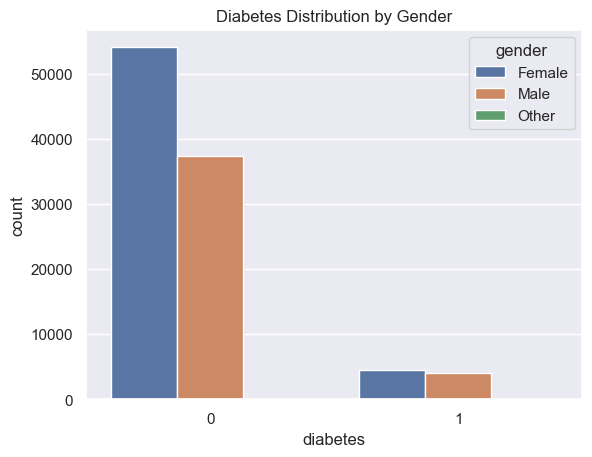

In [203]:
sns.countplot(x=data['diabetes'], hue=data['gender'])
plt.title('Diabetes Distribution by Gender')
plt.show()

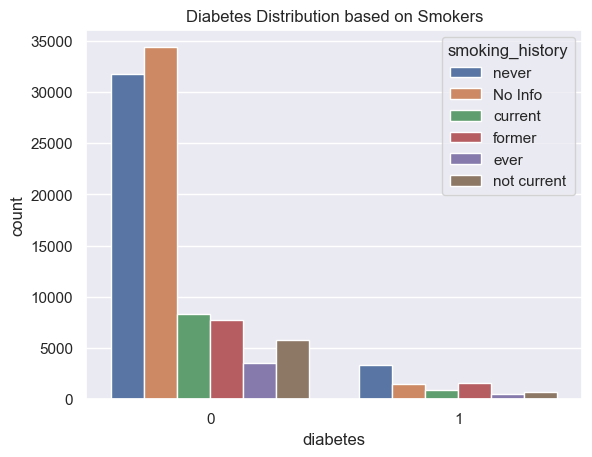

In [204]:
sns.countplot(x=data['diabetes'], hue=data['smoking_history'])
plt.title('Diabetes Distribution based on Smokers')
plt.show()

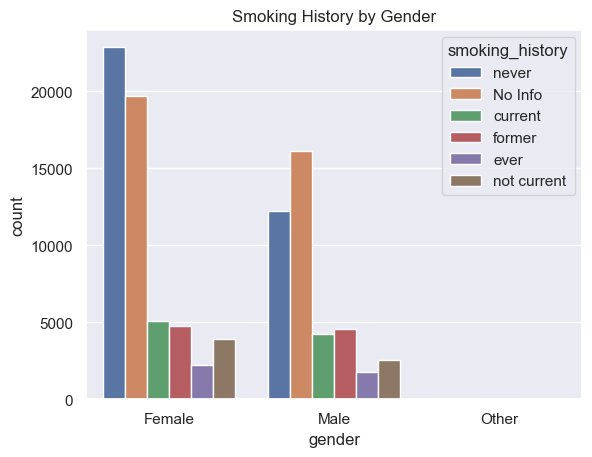

In [206]:
sns.countplot(x=data['gender'], hue=data['smoking_history'])
plt.title('Smoking History by Gender')
plt.show()

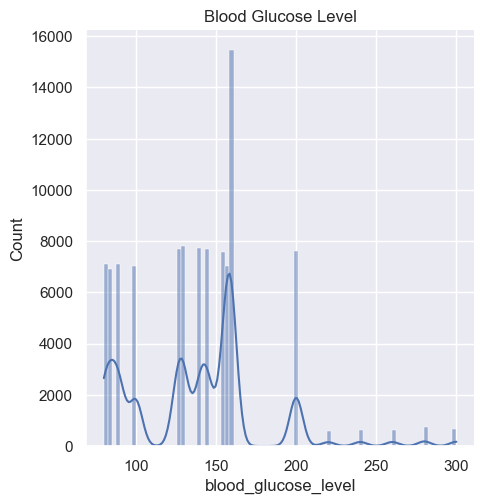

In [209]:
sns.displot(data['blood_glucose_level'], kde=True)
plt.title('Blood Glucose Level')
plt.show()

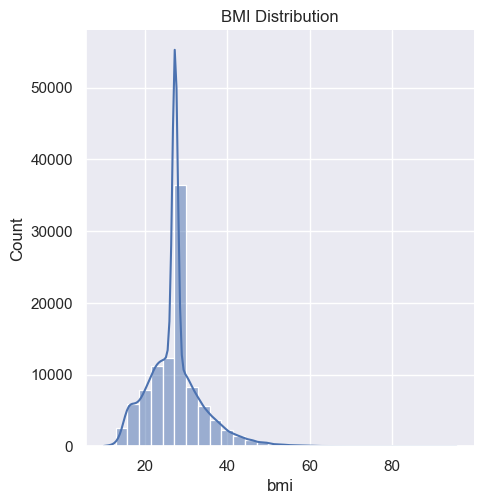

In [210]:
sns.displot(data['bmi'], bins=30, kde=True)
plt.title('BMI Distribution')
plt.show()

# Preprocessing

### Remove outliers

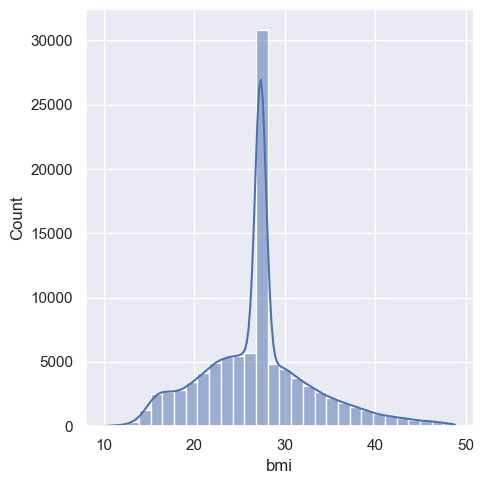

In [213]:
# A BMI of 70 is almost not certainly feasible for most people. We can safely remove it
q = data['bmi'].quantile(.99)
data = data[data['bmi'] < q]
sns.displot(data['bmi'], bins=30, kde=True)
plt.show()

### Encoding categories

In [66]:
# Gender
data = data[data['gender'] != 'Other']
data['gender'] = data['gender'].map({'Male': 0, 'Female': 1})

In [72]:
# Smoking history
from sklearn.preprocessing import LabelEncoder

data['smoking_history'].unique()

array(['never', 'No Info', 'current', 'former', 'ever', 'not current'],
      dtype=object)

In [74]:
le = LabelEncoder()

data['smoking_history'] = le.fit_transform(data['smoking_history'])

In [76]:
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1,80.0,0,1,4,25.19,6.6,140,0
1,1,54.0,0,0,0,27.32,6.6,80,0
2,0,28.0,0,0,4,27.32,5.7,158,0
3,1,36.0,0,0,1,23.45,5.0,155,0
4,0,76.0,1,1,1,20.14,4.8,155,0


In [83]:
data.shape

(98982, 9)

# Model

In [86]:
X = data.drop(['diabetes'], axis=1)
y = data['diabetes']

### Standardize

In [89]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

### Splitting

In [92]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### Training

In [117]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

models = {
    'Logistic Regression': LogisticRegression(penalty='l2'),
    'KNN': KNeighborsClassifier(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}
    
def model_training(models, X_train, X_test, y_train, y_test):
    for model_name, model in models.items():
        model = model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        print(f'{model_name} Metrics:')
        print('Accuracy:', accuracy_score(y_test, y_pred))
        print()
        print(classification_report(y_test, y_pred))
        print()
        
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{model_name} Confusion Matrix')
        plt.show()

Logistic Regression Metrics:
Accuracy: 0.9618629085214931

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18185
           1       0.86      0.63      0.73      1612

    accuracy                           0.96     19797
   macro avg       0.91      0.81      0.85     19797
weighted avg       0.96      0.96      0.96     19797




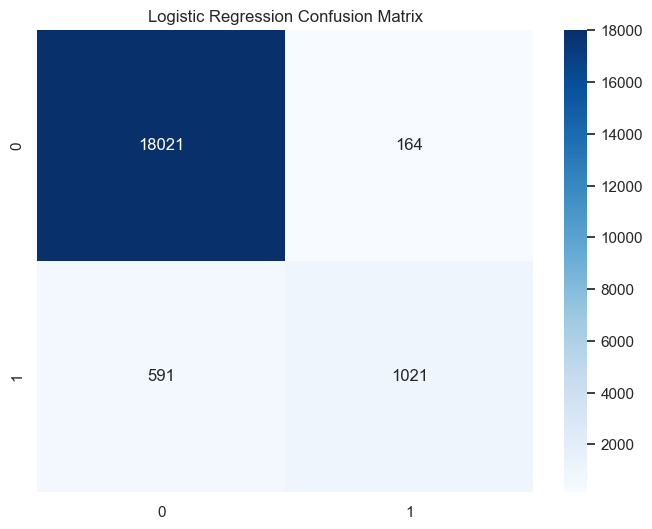

KNN Metrics:
Accuracy: 0.9626205990806688

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18185
           1       0.88      0.63      0.73      1612

    accuracy                           0.96     19797
   macro avg       0.92      0.81      0.86     19797
weighted avg       0.96      0.96      0.96     19797




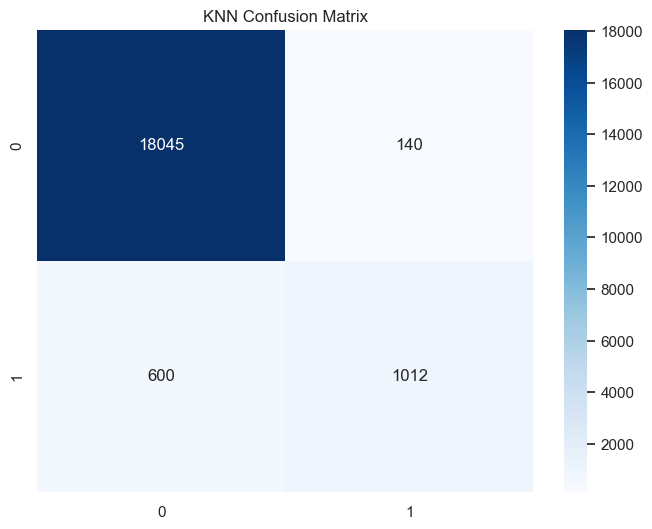

C:\Users\Micha\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:22:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Metrics:
Accuracy: 0.9716118603828863

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18185
           1       0.95      0.69      0.80      1612

    accuracy                           0.97     19797
   macro avg       0.96      0.84      0.89     19797
weighted avg       0.97      0.97      0.97     19797




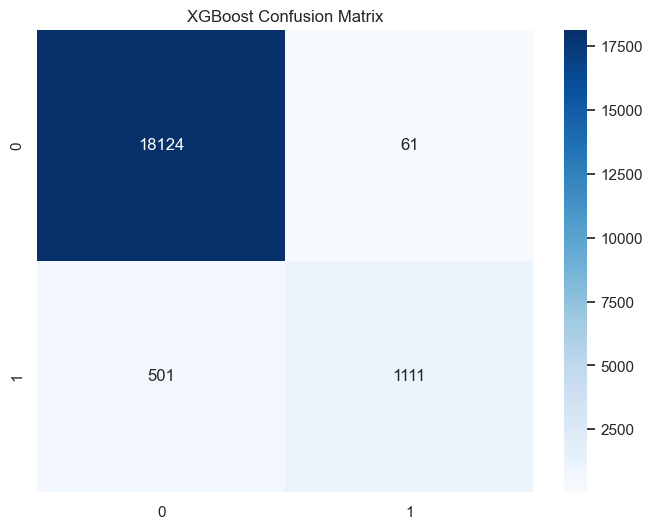

In [119]:
model_training(models, X_train, X_test, y_train, y_test)

# Deep Learning

In [124]:
# Convert X and y to numpy
X2 = X.to_numpy().astype(float)
y2 = y.to_numpy().astype(int)

In [130]:
X2.shape, y.shape

((98982, 8), (98982,))

In [128]:
# Scale
scaler.fit(X2)
X2_scaled = scaler.transform(X2)

In [132]:
# Shuffle
shuffled = np.arange(X2.shape[0])
np.random.shuffle(shuffled)

X2_scaled = X2_scaled[shuffled]
y2 = y2[shuffled]

In [134]:
# Splitting with validation
X_train, X_temp, y_train, y_temp = train_test_split(X2_scaled, y2, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

In [136]:
# Model
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],)),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

C:\Users\Micha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [177]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate = 0.001)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [179]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=2)

history = model.fit(X_train, y_train,
                    epochs = 100, batch_size=2048,
                    validation_data = (X_val, y_val),
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9722 - loss: 0.0800 - val_accuracy: 0.9741 - val_loss: 0.0761
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9727 - loss: 0.0787 - val_accuracy: 0.9739 - val_loss: 0.0760
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9731 - loss: 0.0788 - val_accuracy: 0.9740 - val_loss: 0.0761
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9727 - loss: 0.0793 - val_accuracy: 0.9742 - val_loss: 0.0761


## Testing

In [180]:
test_loss, test_acc = model.evaluate(X_test, y_test)

124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9756 - loss: 0.0691


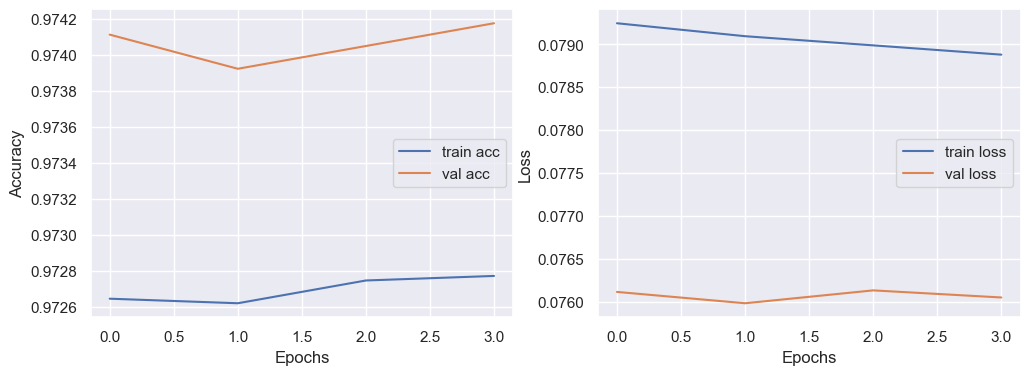

In [181]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [230]:
y_pred = model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)

124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [232]:
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3630
           1       0.98      0.70      0.82       330

    accuracy                           0.97      3960
   macro avg       0.98      0.85      0.90      3960
weighted avg       0.97      0.97      0.97      3960



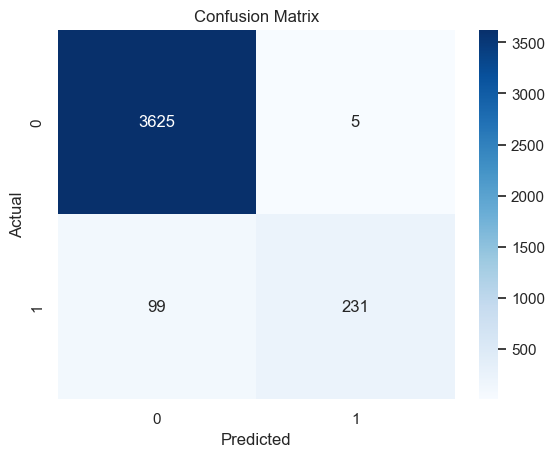

In [234]:
cm = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()